In [30]:
"""
    (Successful) Attempt for the controlled version:
"""
import numpy as np
import qiskit
from qiskit.quantum_info import state_fidelity
from numpy import linalg as LA
import qib
import matplotlib.pyplot as plt
import scipy
import h5py

import sys
sys.path.append("../../src/brickwall_sparse")
from utils_sparse import construct_ising_local_term, reduce_list, X, I2, get_perms
from ansatz_sparse import ansatz_sparse
import rqcopt as oc
from scipy.sparse.linalg import expm_multiply
from qiskit.quantum_info import random_statevector


L = 6
t = .75
latt = qib.lattice.IntegerLattice((L, ), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
J, h, g = (1, 0, 3)
hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix()
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(hamil, k=10)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]

X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
Y = np.array([[0, -1j], [1j, 0]])
I2 = np.array([[1, 0], [0, 1]])


hloc = construct_ising_local_term(J, 0, 0, ndim=2) + g*(np.kron(X, I2)+np.kron(I2, X))/2
V1 = scipy.linalg.expm(-1j*t*hloc/2)
V2 = scipy.linalg.expm(-1j*t*hloc)
YZ = np.kron(Y, Z)
Vlist_start = [YZ, np.kron(I2, I2), V1, V2, V1, np.kron(I2, I2),  YZ]
Vlist_reduced = [V1, V2, V1]

control_layers = [0, 1, 5, 6]
perms_extended = [[[i for i in range(L)]] if i%2==0 else [[i for i in range(1, L)]+[0]] for i in range(len(Vlist_start))]
perms_ext_reduced = []
for i, perm in enumerate(perms_extended):
    if i not in control_layers:
        perms_ext_reduced.append(perm)


# 12 layers with 6 being controlled, 9 parameters in total.
state = random_statevector(2**L).data
print("Trotter error of the starting point: ", (np.linalg.norm(ansatz_sparse(Vlist_start, L, perms_extended, state) - expm_multiply(
    1j * t * hamil, state), ord=2) + np.linalg.norm(ansatz_sparse(Vlist_reduced, L, perms_ext_reduced, state) - expm_multiply(
    -1j * t * hamil, state), ord=2))/2)

print('fidelity: ', (state_fidelity(ansatz_sparse(Vlist_start, L, perms_extended, state), expm_multiply(
    1j * t * hamil, state)) + state_fidelity(ansatz_sparse(Vlist_reduced, L, perms_ext_reduced, state), expm_multiply(
    -1j * t * hamil, state)))/2)

Trotter error of the starting point:  0.6072181910423273
fidelity:  0.6671282348891012


Current error:  0.6617802909998816
Current error:  0.6502554280485446
Current error:  0.6274456740675607
Current error:  0.5826889691748725
Current error:  0.49591869841774283
Current error:  0.3924569630258701
Current error:  0.30112998891464904
Current error:  0.2297767704793719
Current error:  0.1905370535887838
Current error:  0.14360194933923182
Current error:  0.12488640690772926
Current error:  0.11130453734923446
Current error:  0.10585290731909669
Current error:  0.10431987219638728
Current error:  0.10328713101713063
Current error:  0.10261312811272402
Current error:  0.10194452917232438
Current error:  0.1012982515344896
Current error:  0.10046144183651795
Current error:  0.09936779274683609
Current error:  0.09801065336051196
0.09801065336051196


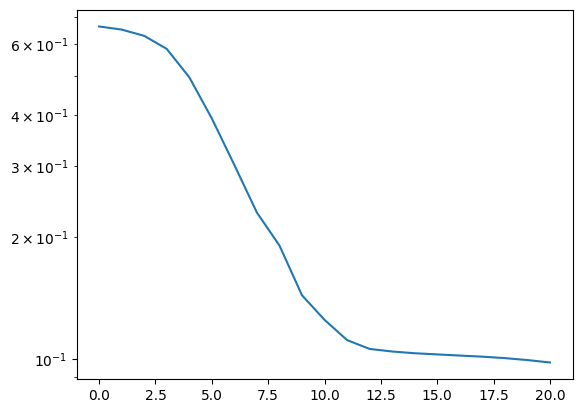

In [31]:
from optimize_sparse import optimize

niter = 20
rS    = 1
Vlist, f_iter, err_iter = optimize(L, hamil, t, Vlist_start, perms_extended, perms_reduced=perms_ext_reduced, 
                                   control_layers=control_layers, rS=rS, niter=niter)
plt.plot(err_iter)
plt.yscale('log')
print(err_iter[-1])

In [40]:
"""
    Test operations.
"""
infids = []
for L in [8, 10, 12, 14, 16]: 
    t = .75
    latt = qib.lattice.IntegerLattice((L, ), pbc=True)
    field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
    J, h, g = (1, 0, 3)
    hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix()
    eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(hamil, k=10)
    idx = eigenvalues.argsort()
    eigenvalues_sort = eigenvalues[idx]
    eigenvectors_sort = eigenvectors[:,idx]
    ground_state = eigenvectors_sort[:, 0]
    
    perms_extended = [[[i for i in range(L)]] if i%2==0 else [[i for i in range(1, L)]+[0]] for i in range(len(Vlist_start))]
    perms_ext_reduced = []
    for i, perm in enumerate(perms_extended):
        if i not in control_layers:
            perms_ext_reduced.append(perm)
    Vlist_reduced = []
    for i, V in enumerate(Vlist):
        if i not in control_layers:
            Vlist_reduced.append(V)
    
    state = random_statevector(2**L).data
    infids.append(1 - (state_fidelity(ansatz_sparse(Vlist, L, perms_extended, state), expm_multiply(
        1j * t * hamil, state)) + state_fidelity(ansatz_sparse(Vlist_reduced, L, perms_ext_reduced, state), expm_multiply(
        -1j * t * hamil, state)))/2)
infids

[0.03723038037506443,
 0.047137315679279146,
 0.05585384366115598,
 0.06500725183269851,
 0.07371434704708835]

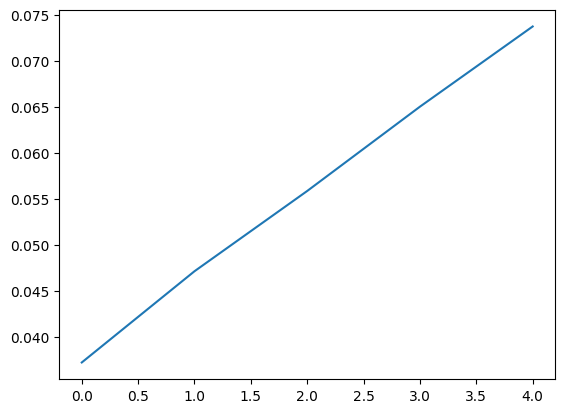

In [41]:
plt.plot(infids)

In [35]:
sys.path.append("../../src/controlled_unitary_optimizer")
sys.path.append("../../src/brickwall_ansatz")
from optimize_3q import optimize_3q 
from utils_3q import make_controlled, random_unitary

Xlists_opt = {}
#perms_qc = [[0, 1], [0, 2], [1, 2], [0, 2], [0, 1], [1, 2], [0, 2], [0, 1], [1, 2]]
perms_qc = [[0, 1], [0, 2], [1, 2]]

for i in control_layers:
    cU = make_controlled(Vlist[i])
    f_best, err_best, Glist_best = (0, 2, None)
    for _ in range(10):
        Xlist_start = [random_unitary(4) for i in range(len(perms_qc))]
        Xlist, f_iter, err_iter = optimize_3q(L, cU, Xlist_start, perms_qc, niter=1000)
        if err_iter[-1] < err_best:
            f_best, err_best, Xlist_best = (f_iter[-1], err_iter[-1], Xlist)
    print("Best f: ", f_best)
    print("Best err: ", err_best)
    Xlists_opt[i] = Xlist_best

Best f:  -7.988975484327331
Best err:  0.06718226241147673
Best f:  -7.985010884580439
Best err:  0.07444873976511641
Best f:  -7.993222659745626
Best err:  0.05284894697278736
Best f:  -7.987177046904607
Best err:  0.07520313323035716


In [36]:
from qiskit import Aer, execute, transpile
from qiskit.circuit.library import CYGate, CZGate, IGate, CXGate
from qiskit.converters import circuit_to_dag
from qiskit.providers.aer.noise import NoiseModel, errors
from qiskit import Aer, execute, transpile
from scipy import sparse as sp

qc = qiskit.QuantumCircuit(L+1)
qc.x(L)
for i, V in enumerate(Vlist):
    layer = i
    if i in control_layers:
        Glist = Xlists_opt[i]
        qc_3 = qiskit.QuantumCircuit(3)
        for j, G in enumerate(Glist):
            qc_3.unitary( G, (3-1-perms_qc[j][1], 3-1-perms_qc[j][0]))

        for perm in perms_extended[layer]:
            for j in range(L//2):
                qc.append(qc_3.to_gate(), [L-perm[2*j]-1, L-perm[2*j+1]-1, L])
        
    else:
        for perm in perms_extended[layer]:
            for j in range(L//2):
                qc.unitary(V, [L-perm[2*j]-1, L-perm[2*j+1]-1])
qc.x(L)


ccU_cxs= []
ccU_errs = []
for t in [.75]:
    state = random_statevector(2**L).data
    qc_ext1 = qiskit.QuantumCircuit(L+1)
    qc_ext1.initialize(state, [i for i in range(L)])
    for i in range(int(t/t)):
        qc_ext1.append(qc.to_gate(), [i for i in range(L+1)])
    backend = Aer.get_backend("statevector_simulator")
    sv1 = execute(transpile(qc_ext1), backend).result().get_statevector().data
    
    qc_ext2 = qiskit.QuantumCircuit(L+1)
    qc_ext2.initialize(state, [i for i in range(L)])
    qc_ext2.x(L)
    for i in range(int(t/t)):
        qc_ext2.append(qc.to_gate(), [i for i in range(L+1)])
    backend = Aer.get_backend("statevector_simulator")
    sv2 = execute(transpile(qc_ext2), backend).result().get_statevector().data

    ket_0 = np.array([1, 0])
    ket_1 = np.array([0, 1])
    exact_v1 = np.kron(ket_0, expm_multiply(1j * t * hamil, state))
    exact_v2 = np.kron(ket_1, expm_multiply(-1j * t * hamil, state))
    #err = (np.linalg.norm(sv1-exact_v1, ord=2) + np.linalg.norm(sv2-exact_v2, ord=2))/2
    err = 1-(state_fidelity(sv1, exact_v1) + state_fidelity(sv2, exact_v2))/2
    
    noise_model = NoiseModel()
    dag = circuit_to_dag(transpile(qc_ext1, basis_gates=noise_model.basis_gates+['unitary', 'initialize', 'cx']))
    count_ops = dag.count_ops()
    
    ccU_errs.append(err)
    ccU_cxs.append(count_ops['unitary'])
    print(f"t={t}, Gate Count: ", count_ops['unitary'], " Trotter error: ", err)

t=0.75, Gate Count:  120  Trotter error:  0.0801052416529272
